#Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Load Data

In [2]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Preprocessing

In [3]:
# type conversion
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [4]:
# for customer profile
transactions_with_customers = transactions.merge(customers, on='CustomerID')
transactions_with_details = transactions_with_customers.merge(products, on='ProductID')

In [5]:
# feature set for clustering
customer_features = transactions_with_details.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    average_spending=('TotalValue', 'mean')
).reset_index()

In [6]:
# normalizing data
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features.drop(['CustomerID'], axis=1))

#PCA

In [7]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(normalized_features)

#Elbow Method
####To find out the optimal value of 'k'
NOTE: as mentioned within the range of 2 to 10

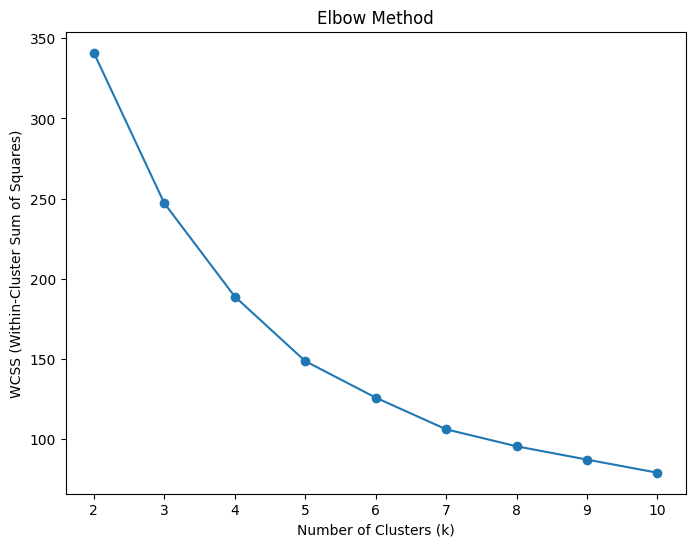

In [8]:
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(normalized_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Clustering
Includes DB(Davis-Bouldin) Index value

In [9]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=0)
customer_features['Cluster'] = kmeans.fit_predict(normalized_features)

In [10]:
db_index = davies_bouldin_score(normalized_features, customer_features['Cluster'])
print("Davis-Bouldin Index:", db_index)

Davis-Bouldin Index: 0.9088862131710539


#Visuals

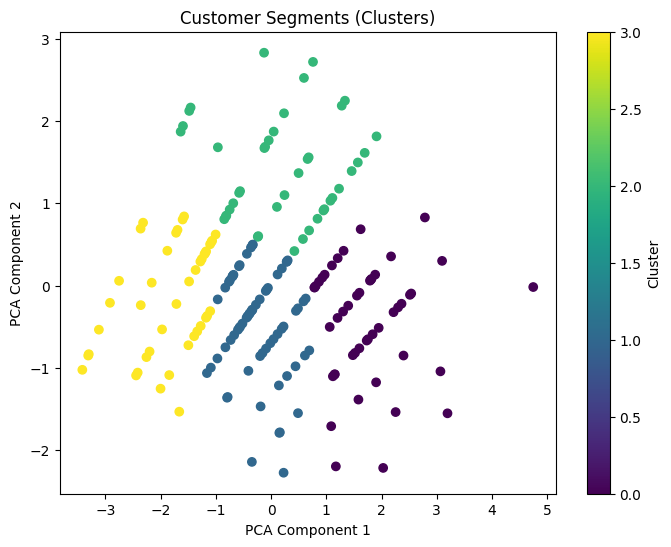

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_features['Cluster'], cmap='viridis')
plt.title('Customer Segments (Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

#Save Clusters

In [12]:
customer_features['CustomerID'] = customer_features['CustomerID']
customer_features.to_csv('Clustered_Customers.csv', index=False)